### Import Necessary Packages

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use('fivethirtyeight')

In [32]:
trips_by_day = pd.read_csv('data/trips_by_day.csv', parse_dates = [0])
dates = trips_by_day.date

trips_by_day.head()

,date,count
0,2010-09-20,212
1,2010-09-21,324
2,2010-09-22,377
3,2010-09-23,373
4,2010-09-24,362


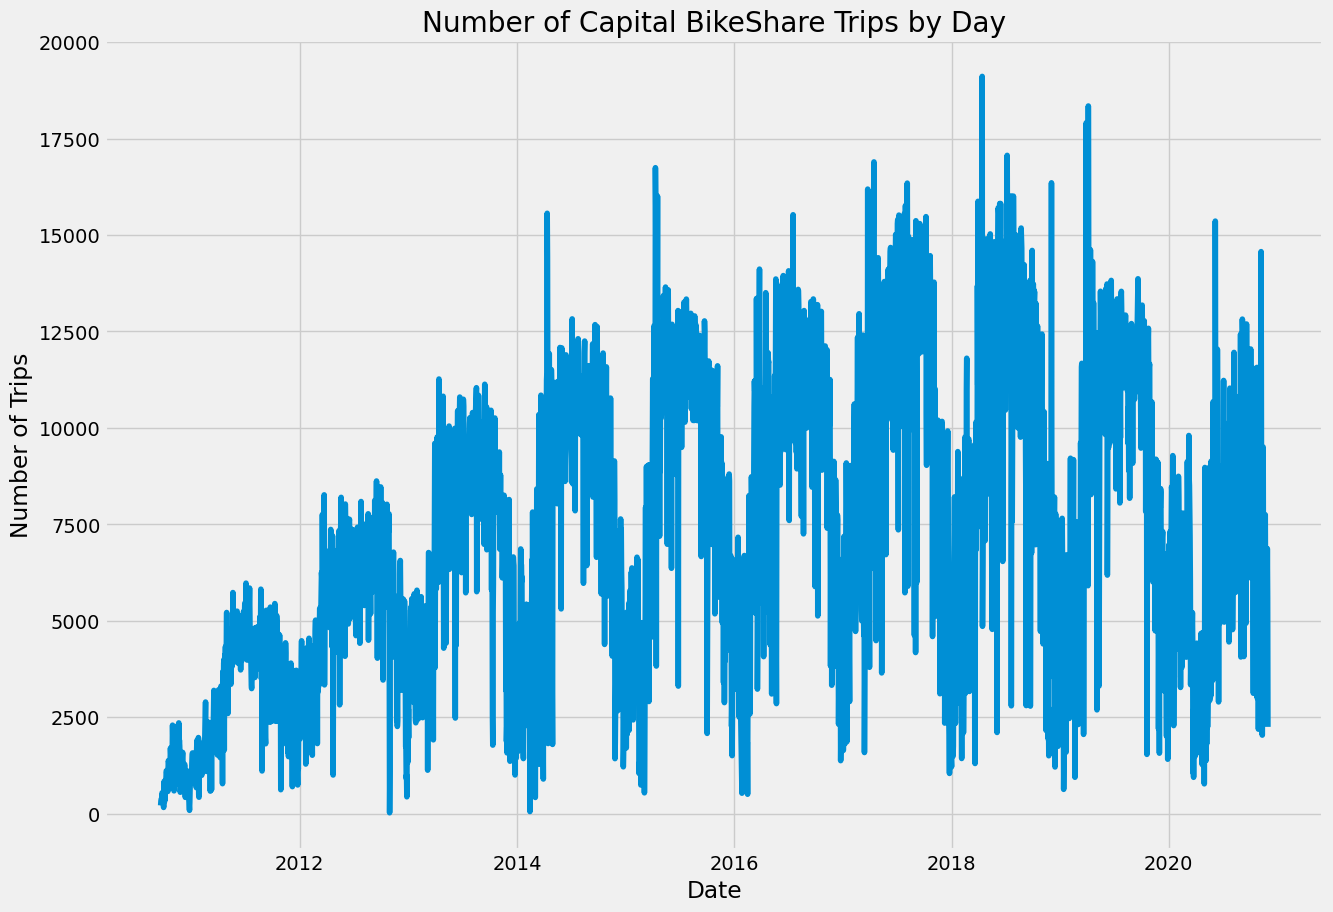

In [33]:
plt.figure(figsize = (14,10))
plt.plot(dates, trips_by_day['count'])
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.title('Number of Capital BikeShare Trips by Day')
plt.show()

With daily data, seasonality and trend are still visible but the data is too noisy to be used for forecasting.

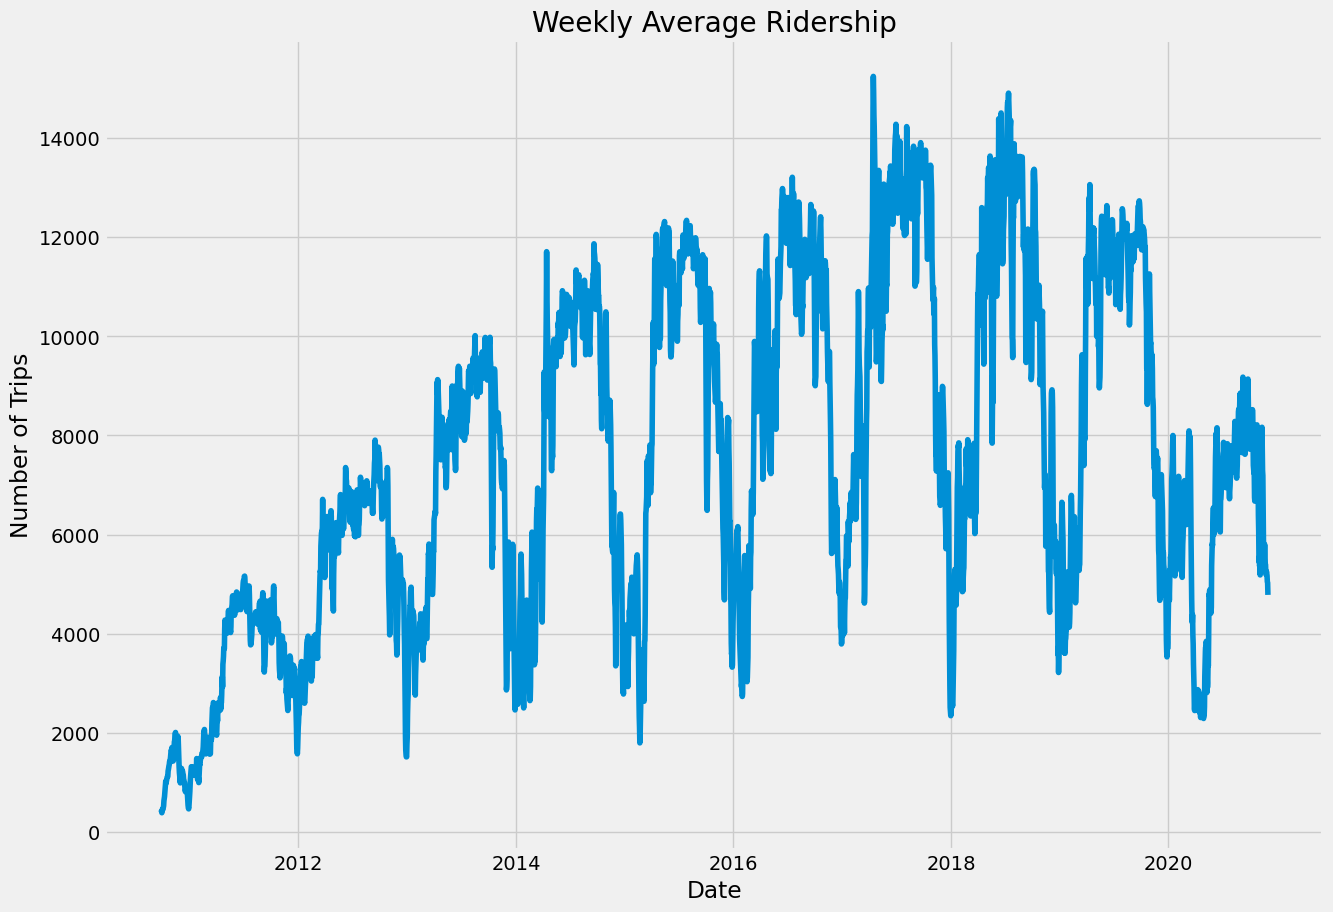

In [34]:
weekly_avg = trips_by_day.rolling(window = 7).mean()
weekly_avg.set_index(dates, inplace = True)

plt.figure(figsize = (14,10))
plt.plot(weekly_avg)
plt.title('Weekly Average Ridership')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

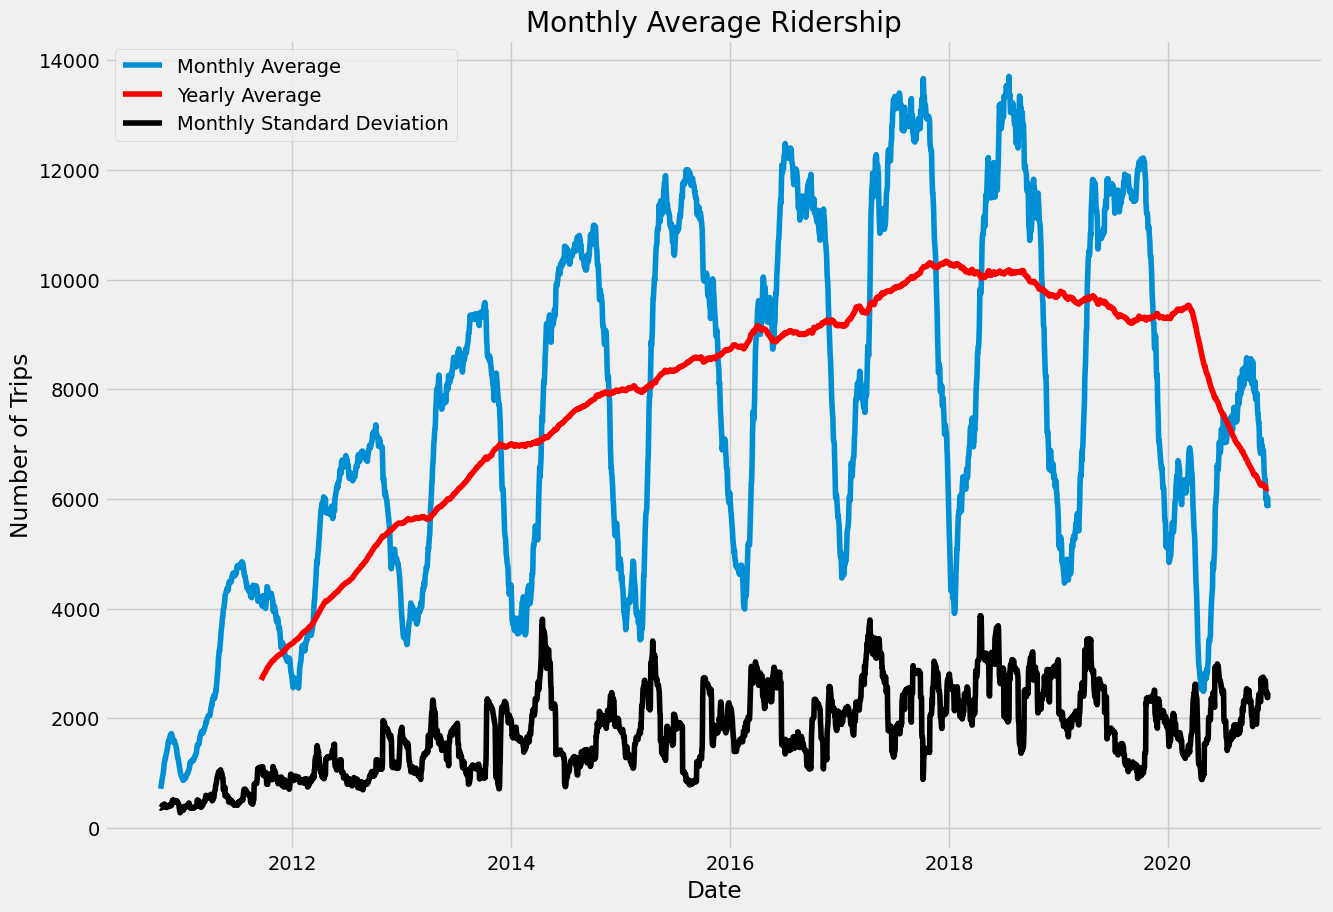

In [35]:
monthly_avg = trips_by_day.rolling(window = 30).mean()
yearly_mean = trips_by_day.rolling(window = 365).mean()
monthly_std = trips_by_day.rolling(window = 30).std()

plt.figure(figsize = (14,10))
plt.plot(dates, monthly_avg)
plt.plot(dates, yearly_mean, color = 'red')
plt.plot(dates, monthly_std, color = 'black')
plt.title('Monthly Average Ridership')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.legend(['Monthly Average', 'Yearly Average', 'Monthly Standard Deviation'])
plt.show()

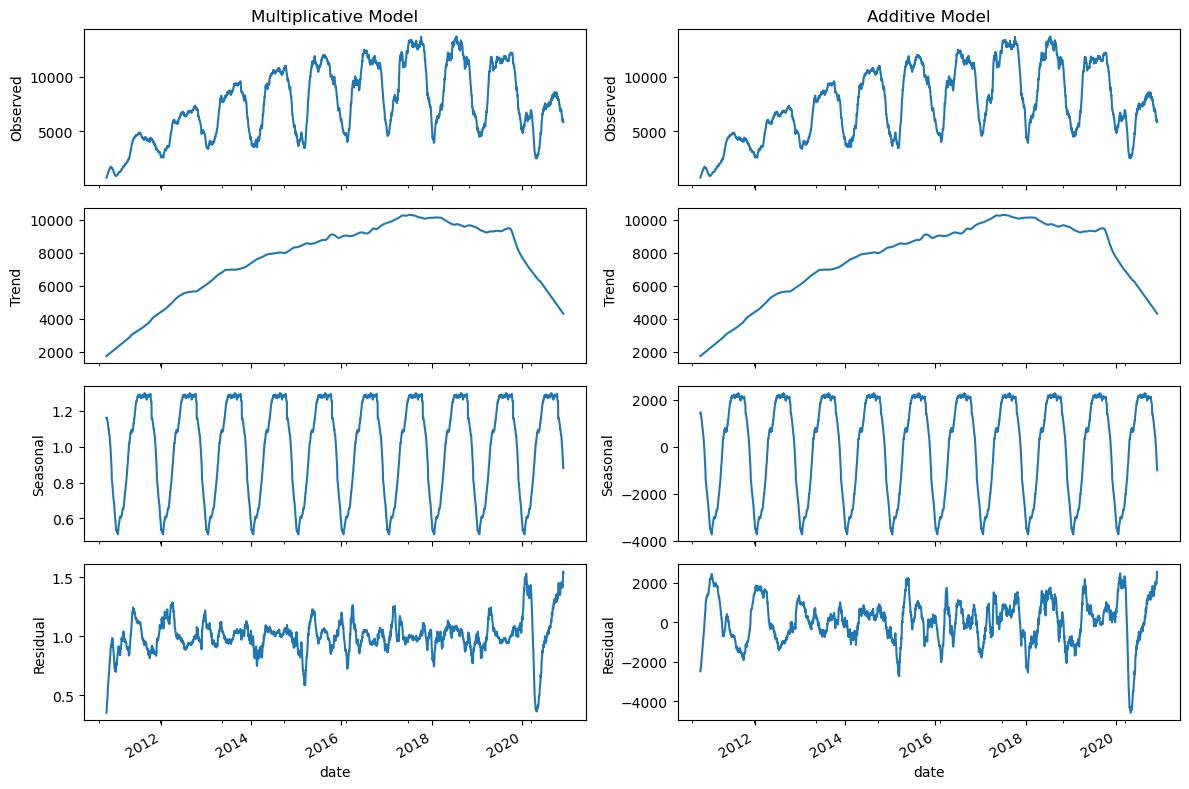

In [36]:
### Decompose time series using Multiplicative/Additive Model ###
plt.style.use('default')
decomposition_mult = seasonal_decompose(monthly_avg.set_index(dates).dropna(), 
                                   model = 'multi', 
                                   period = 365, 
                                   extrapolate_trend = 'freq')

decomposition_add = seasonal_decompose(monthly_avg.set_index(dates).dropna(), 
                                   model = 'add', 
                                   period = 365, 
                                   extrapolate_trend = 'freq')

### Plot decomposed time series ###
def plot_decomposition(res, axes):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(4,2, sharex = True, figsize = (12,8))

plot_decomposition(decomposition_mult, axes[:,0])
axes[0][0].set_title('Multiplicative Model')

plot_decomposition(decomposition_add, axes[:,1])
axes[0][1].set_title('Additive Model')

plt.tight_layout()
plt.show()

### Stationarize Time Series

In [37]:
monthly_avg = monthly_avg.set_index(dates).dropna()
monthly_avg['trend'] = decomposition_mult.trend

In [38]:
monthly_avg['first_diff'] = monthly_avg['count'] - monthly_avg['count'].shift(1)

In [39]:
monthly_avg['detrend'] = monthly_avg['count'] - monthly_avg['trend']

In [40]:
def test_stationarity(series):
    
    test_dates = series.index
    
    # Rolling statistics
    rol_avg = series.rolling(window = 365).mean()
    rol_std = series.rolling(window = 365).std()
    
    # Plotting Statistics
    plt.figure(figsize = (8,5))
    plt.plot(series)
    plt.plot(test_dates, rol_avg, color = 'r')
    plt.plot(test_dates, rol_std, color = 'k')
    plt.xlabel('Date')
    plt.legend(['Series', 'Yearly Rolling Mean', 'Yearly Rolling St. Dev.'])
    plt.show()
    
    # Dickey-Fuller Test:
    test = adfuller(series, autolag = 'AIC')
    result = pd.Series(test[0:4], index = ['Test Statistic', 'P-value', '# of Lags Used', '# of Observations used'])
    for key, value in test[4].items():
        result[f'Critical Value ({key})'] = value
    
    print('Dickey-Fuller Test Results:')
    print(result)

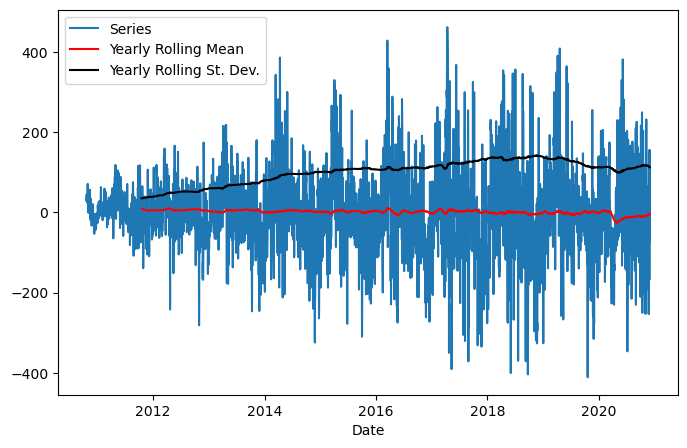

Dickey-Fuller Test Results:
Test Statistic           -9.947097e+00
P-value                   2.572332e-17
# of Lags Used            3.000000e+01
# of Observations used    3.660000e+03
Critical Value (1%)      -3.432138e+00
Critical Value (5%)      -2.862330e+00
Critical Value (10%)     -2.567191e+00
dtype: float64


In [41]:
test_stationarity(monthly_avg['first_diff'].dropna())

Taking the first difference of the data resulted in a pretty stationary time series as can be seen from the extremely low P-value. Let's see how removing the trend performs.

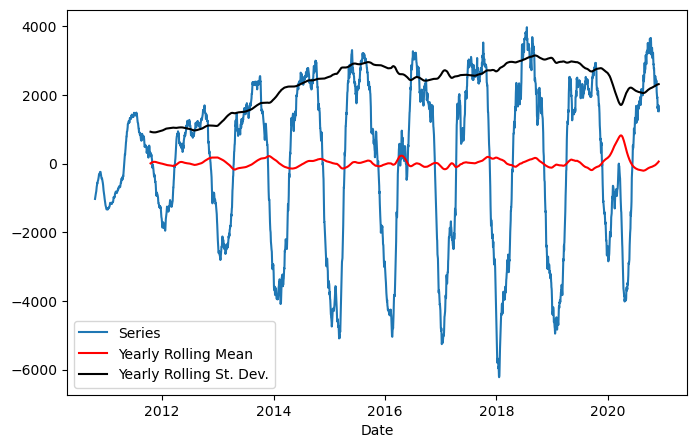

Dickey-Fuller Test Results:
Test Statistic              -3.310125
P-value                      0.014432
# of Lags Used              30.000000
# of Observations used    3661.000000
Critical Value (1%)         -3.432137
Critical Value (5%)         -2.862330
Critical Value (10%)        -2.567190
dtype: float64


In [42]:
test_stationarity(monthly_avg['detrend'])

By just subtracting the overall trend from the data, the time series becomes somewhat stationary but is not any better than just first differencing. Therefore, the first differenced data will be used. However, there is still some seasonality patterns that are visible after first differencing. I will attempt to remove this using seasonal differencing.

In [43]:
monthly_avg['seasonal_difference'] = monthly_avg['first_diff'] - monthly_avg['first_diff'].shift(365)

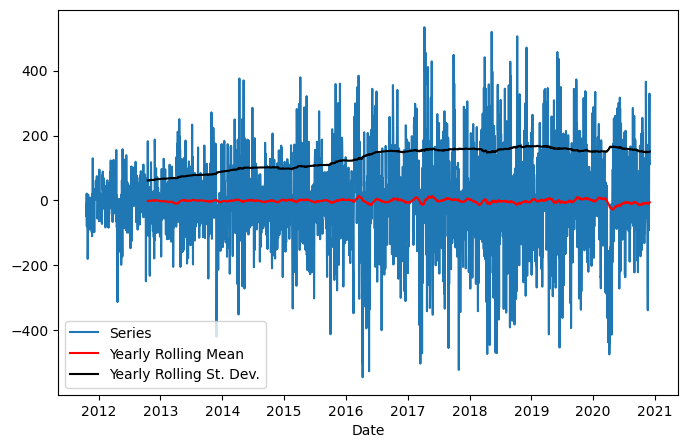

Dickey-Fuller Test Results:
Test Statistic           -1.849278e+01
P-value                   2.125690e-30
# of Lags Used            2.900000e+01
# of Observations used    3.296000e+03
Critical Value (1%)      -3.432336e+00
Critical Value (5%)      -2.862417e+00
Critical Value (10%)     -2.567237e+00
dtype: float64


In [44]:
test_stationarity(monthly_avg['seasonal_difference'].dropna())

First differencing and removing the seasonality resulted in a very stationary time series that will be perfect for analysis.

### Plotting ACF and PACF

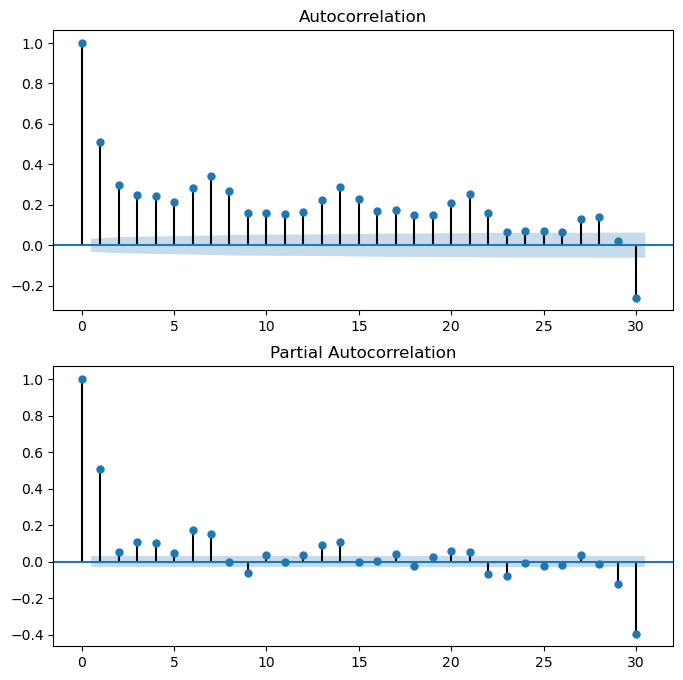

In [68]:
fig = plt.figure(figsize = (8,8))

ax1 = fig.add_subplot(211)
acf = plot_acf(monthly_avg['first_diff'].dropna(), lags = 30, ax = ax1)

ax2 = fig.add_subplot(212)
pacf = plot_pacf(monthly_avg['first_diff'].dropna(), lags = 30, ax = ax2)

### Modeling with ARIMA and SARIMAX

In [72]:
train_values = monthly_avg['seasonal_difference'].dropna().values
model_arima = ARIMA(train_values, order = (1,2,0))
arima_results = model_arima.fit()
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3326
Model:                 ARIMA(1, 2, 0)   Log Likelihood              -22210.057
Date:                Wed, 13 Jan 2021   AIC                          44424.114
Time:                        23:54:14   BIC                          44436.332
Sample:                             0   HQIC                         44428.486
                               - 3326                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5805      0.012    -48.460      0.000      -0.604      -0.557
sigma2      3.726e+04    744.935     50.022      0.000    3.58e+04    3.87e+04
Ljung-Box (Q):                     2279.98   Jarque-